In [1]:
import numpy as np
import os
import pandas as pd
import random
import re
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import unicodedata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import math


from __future__ import unicode_literals, print_function, division
from io import open
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LENGTH = 10


In [2]:
SOS_token = 0
EOS_token = 1

# Class representing a language with functions to add words and sentences
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Preprocessing unicode characters
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Function to normalize string by lowercasing, trimming, and removing non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [4]:
# Function to read language pairs from a file
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    lines = ['\t'.join(line.split('\t')[:2]) for line in lines]
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
# functions to filter the dataset 
def filterPair(p):
    return (len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
# Function to read and prepare the data for translation
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'spa', True)
pairs_test = []
pairs_train = []
# Reading the standard test file
df_test = pd.read_excel("test.xlsx")
for pair in pairs:
    if pair[0] in list(df_test["Spanish"]):
        pairs_test.append([pair[0], pair[1]])
    else:
        pairs_train.append([pair[0], pair[1]])
pairs = pairs_train
print(random.choice(pairs))

Reading lines...
Read 141370 sentence pairs
Trimmed to 119484 sentence pairs
Counting words...
Counted words:
spa 23395
eng 12091
['eres muy poco flexible', 'you re too inflexible']


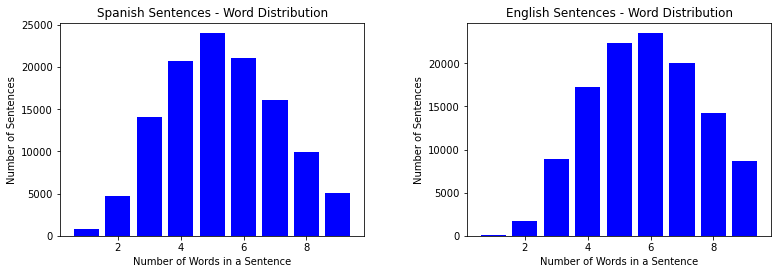

In [7]:
# Function to plot the distribution of words
def plot_word_distribution(sentences, plot_title, i):
    sentence_lengths = [len(sentence.split()) for sentence in sentences]
    word_distribution = Counter(sentence_lengths)
    plt.subplot(1, 2, i)
    plt.bar(word_distribution.keys(), word_distribution.values(), color='blue')
    plt.xlabel('Number of Words in a Sentence')
    plt.ylabel('Number of Sentences')
    plt.title(f'{plot_title} - Word Distribution')

sentences_list1 = [pair[0] for pair in pairs]
sentences_list2 = [pair[1] for pair in pairs]
plt.figure(figsize=(12, 5))
plot_word_distribution(sentences_list1, 'Spanish Sentences', 1)
plot_word_distribution(sentences_list2, 'English Sentences', 2)
plt.tight_layout(pad=5)
plt.show()


In [8]:
# Encoder Class using LSTM
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.lstm(embedded)
        return output, hidden

In [9]:
# Decoder Class using LSTM

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden, decoder_cell = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, (decoder_hidden, decoder_cell) = self.forward_step(
                decoder_input, (decoder_hidden, decoder_cell)
            )
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, (decoder_hidden, decoder_cell), None

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        return output, hidden

In [10]:
# Attention Class

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.lstm = nn.LSTM(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden, decoder_cell = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, (decoder_hidden, decoder_cell), attn_weights = self.forward_step(
                decoder_input, (decoder_hidden, decoder_cell), encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, (decoder_hidden, decoder_cell), attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        query = hidden[0].permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_lstm = torch.cat((embedded, context), dim=2)

        output, hidden = self.lstm(input_lstm, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Funtion to get dataloader
def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'spa', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    return input_lang, output_lang, train_dataloader

In [12]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, (encoder_hidden, encoder_cell) = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, (encoder_hidden, encoder_cell), target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [13]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
# training function
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses, n_epochs)

In [15]:
def showPlot(points, n_epochs):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(range(1, n_epochs + 1), points)
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.title("Training Loss vs Epochs")

In [16]:
# Function to generate responses
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Reading lines...
Read 141370 sentence pairs
Trimmed to 119484 sentence pairs
Counting words...
Counted words:
spa 23395
eng 12091
0m 18s (- 4m 19s) (1 6%) 3.5893
0m 36s (- 3m 55s) (2 13%) 2.6261
0m 54s (- 3m 36s) (3 20%) 2.2487
1m 12s (- 3m 18s) (4 26%) 1.9970
1m 30s (- 3m 0s) (5 33%) 1.8002
1m 48s (- 2m 43s) (6 40%) 1.6334
2m 7s (- 2m 26s) (7 46%) 1.4867
2m 25s (- 2m 7s) (8 53%) 1.3579
2m 42s (- 1m 48s) (9 60%) 1.2471
2m 59s (- 1m 29s) (10 66%) 1.1502
3m 16s (- 1m 11s) (11 73%) 1.0657
3m 33s (- 0m 53s) (12 80%) 0.9933
3m 50s (- 0m 35s) (13 86%) 0.9298
4m 7s (- 0m 17s) (14 93%) 0.8733
4m 24s (- 0m 0s) (15 100%) 0.8243


<Figure size 432x288 with 0 Axes>

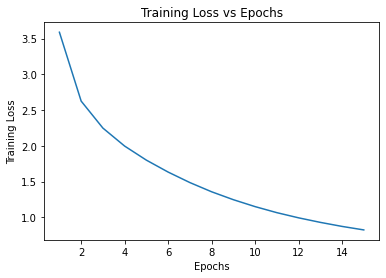

In [18]:
hidden_size = 128
batch_size = 256

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 15, print_every=1, plot_every=1)

In [19]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> no seas idiota
= don t be a jerk
< not be a jerk <EOS>

> fuiste tu quien sugirio ver esa pelicula
= it was you that suggested seeing that movie
< you were that who would know that movie <EOS>

> el nunca rompe sus promesas
= he never breaks his promises
< he never breaks his promises <EOS>

> eso suena bastante tonto
= that just sounds stupid
< that sounds pretty stupid <EOS>

> la calculadora es una invencion maravillosa
= the calculator is a wonderful invention
< the calculator is a wonderful invention <EOS>

> se que ustedes estan enamorados de mi
= i know that you re in love with me
< i know you re in love with me <EOS>

> necesito encontrar mi lapicera
= i need to find my pen
< i need to find my pen <EOS>

> el lucia como si hubiera visto a un fantasma
= he looked as if he had seen a ghost
< he was as if he saw a ghost <EOS>

> cuanto cuesta una suscripcion a un periodico ?
= how much does a newspaper subscription cost ?
< how much is a tie last night ? <EOS>

> eso seria genia

In [20]:
# Generate Predictions for Test set
input_sents = []
target_sents = []
pred_sents = []

for pair in tqdm(pairs_test):
    input_sents.append(pair[0])
    target_sents.append(pair[1])
    output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
    output_sentence = ' '.join(output_words[:-1])
    pred_sents.append(output_sentence)

100%|██████████| 2848/2848 [00:20<00:00, 136.00it/s]


input = mido lo mismo que tu
output = i m doing that right <EOS>


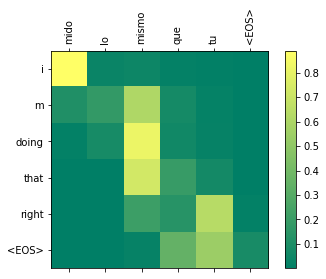

input = el es la unica persona que puede hacerlo
output = he is the only person i can do it <EOS>


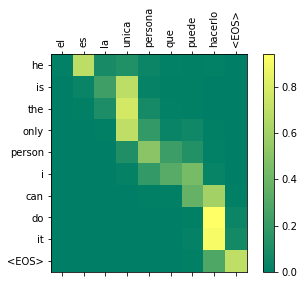

input = voy a echar de menos a tom
output = i m going to miss tom <EOS>


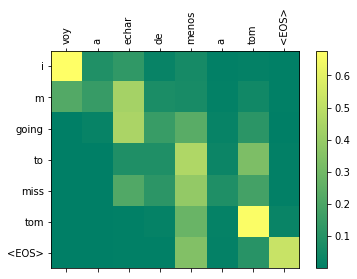

input = estoy esperando una carta suya
output = i m waiting for a letter <EOS>


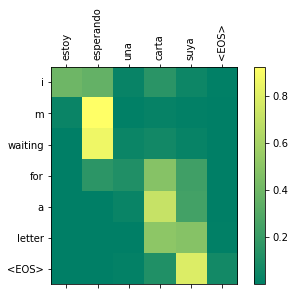

In [21]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='summer')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


# Function to visualize attention
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('mido lo mismo que tu')

evaluateAndShowAttention('el es la unica persona que puede hacerlo')

evaluateAndShowAttention('voy a echar de menos a tom')

evaluateAndShowAttention('estoy esperando una carta suya')

In [22]:
# Calculate BLEU score
bleu = BLEU()
result = bleu.corpus_score(target_sents, [pred_sents])

In [23]:
result

BLEU = 50.18 74.1/55.3/43.6/35.5 (BP = 1.000 ratio = 1.001 hyp_len = 16899 ref_len = 16880)

In [24]:
# Calculate ROUGE scores

total_r1 = 0
total_r2 = 0
total_rl = 0
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for pred, target in zip(pred_sents, target_sents):
    scores = scorer.score(pred, target)
    total_r1 += scores['rouge1'].fmeasure
    total_r2 += scores['rouge2'].fmeasure
    total_rl += scores['rougeL'].fmeasure
    
print("ROGUE-1", 100*total_r1/len(pred_sents))
print("ROGUE-2", 100*total_r2/len(pred_sents))
print("ROGUE-L", 100*total_rl/len(pred_sents))


ROGUE-1 74.68081851710194
ROGUE-2 55.58029575761327
ROGUE-L 73.94407613756584
